<a href="https://colab.research.google.com/github/JuanAquino22/project_ia/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chatbot RAG para Guaraní - Idioma de Bajo Recursos

Este notebook implementa un sistema de chatbot con RAG (Retrieval-Augmented Generation) para el idioma guaraní.

## Objetivos:
1. Comparar 2 modelos de LLM (GPT-3.5 Turbo vs Claude 3.5 Sonnet)
2. Evaluar rendimiento con y sin RAG
3. Comparar few-shot, zero-shot y RAG
4. Evaluar si el idioma de bajo recursos se beneficia del RAG

## Estructura:
- Instalación de dependencias
- Carga de datos desde PDF de gramática guaraní
- Implementación de RAG con FAISS
- Configuración de LLMs con OpenRouter
- Evaluación y comparación de modelos

## 1. Instalación de Dependencias

In [7]:
import warnings
warnings.filterwarnings("ignore")

# Instalación de librerías necesarias para RAG + LLMs (OpenRouter compatible)
!pip install -q -U \
  langchain langchain-core langchain-community langchain-text-splitters \
  chromadb sentence-transformers faiss-cpu \
  transformers torch accelerate datasets \
  tiktoken openai python-dotenv pymupdf

print("✓ Dependencias instaladas correctamente")



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 765.3 kB/s eta 0:00:00
   ━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.9/594.3 MB 2.3 MB/s eta 0:03:11
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3

## 2. Configuración e Importaciones

In [8]:
import os
import json
from typing import List, Dict, Any
from getpass import getpass
import fitz  # PyMuPDF

# LangChain (API moderna)
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS, Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough  # Para construir la cadena RAG moderna

# Transformers (para pruebas con modelos locales si hace falta)
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch

# Utilidades
import numpy as np
from datasets import load_dataset
import warnings
warnings.filterwarnings("ignore")

print("✓ Importaciones completadas correctamente")


✓ Importaciones completadas correctamente


In [12]:
import os
import torch

print("Configurando API Keys desde variables de entorno...")

# === OpenRouter API Key ===
# La variable 'OPENROUTER_API_KEY' ya está definida en el kernel. La usamos directamente.
if 'OPENROUTER_API_KEY' in globals(): # Verifica si la variable Python existe
    os.environ["OPENROUTER_API_KEY"] = OPENROUTER_API_KEY
    print("✓ OPENROUTER_API_KEY cargada correctamente desde la variable del kernel.")
else:
    raise ValueError("❌ ERROR: No se encontró la variable Python 'OPENROUTER_API_KEY'. Asegúrate de que esté definida en el entorno de Colab (por ejemplo, en Secrets o con un getpass previo).")

# === HuggingFace Token (opcional) ===
# Usamos HF_TOKEN si está definida en el kernel, de lo contrario verificamos las variables de entorno.
if 'HF_TOKEN' in globals():
    os.environ["HUGGINGFACE_TOKEN"] = HF_TOKEN
    print("✓ HUGGINGFACE_TOKEN cargado correctamente desde la variable del kernel.")
elif "HF_TOKEN" in os.environ:
    os.environ["HUGGINGFACE_TOKEN"] = os.environ["HF_TOKEN"]
    print("✓ HUGGINGFACE_TOKEN cargado correctamente desde las variables de entorno.")
else:
    print("⚠ HF_TOKEN no encontrado (solo importa si cargarás modelos privados).")

# === Configuración del dispositivo ===
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\n✓ Usando dispositivo: {device}")

if device == "cuda":
    print(f"  GPU detectada: {torch.cuda.get_device_name(0)}")
    print(f"  Memoria disponible: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Configurando API Keys desde variables de entorno...
✓ OPENROUTER_API_KEY cargada correctamente desde la variable del kernel.
✓ HUGGINGFACE_TOKEN cargado correctamente desde la variable del kernel.

✓ Usando dispositivo: cpu


## 3. Carga de Datos - PDF de Gramática Guaraní

En esta sección cargamos el PDF real de gramática guaraní y lo procesamos para crear chunks semánticamente coherentes.

In [13]:
import fitz  # PyMuPDF

def extract_text_from_pdf(pdf_path: str) -> str:
    """
    Extrae texto de un archivo PDF usando PyMuPDF.

    Args:
        pdf_path: Ruta al archivo PDF.

    Returns:
        Texto extraído del PDF (string).
    """
    try:
        doc = fitz.open(pdf_path)
        text = ""

        print(f"📘 Procesando PDF: {pdf_path}")
        print(f"   Total de páginas: {len(doc)}")

        for page_num, page in enumerate(doc, start=1):
            page_text = page.get_text()
            text += f"\n--- Página {page_num} ---\n{page_text}"

            if page_num % 10 == 0:
                print(f"   • Páginas procesadas: {page_num}")

        doc.close()

        print(f"✓ Extracción completada ({len(text)} caracteres extraídos)")
        return text.strip()

    except Exception as e:
        print(f"❌ Error al procesar el PDF: {e}")
        return ""


# ========================
# OPCIÓN 1: Subir archivo al Colab
# ========================
# Si quieres subir el PDF manualmente:
# from google.colab import files
# uploaded = files.upload()
# PDF_PATH = list(uploaded.keys())[0]

# ========================
# OPCIÓN 2: Usar Google Drive
# ========================
# from google.colab import drive
# drive.mount('/content/drive')
# PDF_PATH = '/content/drive/MyDrive/GramaticaGuarani.pdf'

# ========================
# OPCIÓN 3: Archivo ya presente en /content
# ========================
PDF_PATH = "/content/GramaticaGuarani.pdf"

# Verificación
if not os.path.exists(PDF_PATH):
    raise FileNotFoundError(f"❌ No se encontró el archivo en: {PDF_PATH}\n"
                            "Sube el PDF o ajusta la ruta.")

# Extraer texto
pdf_text = extract_text_from_pdf(PDF_PATH)

# Vista previa
print("\n" + "="*60)
print("MUESTRA DEL TEXTO EXTRAÍDO (primeros 500 caracteres):")
print("="*60)
print(pdf_text[:500])
print("...")

📘 Procesando PDF: /content/GramaticaGuarani.pdf
   Total de páginas: 260
   • Páginas procesadas: 10
   • Páginas procesadas: 20
   • Páginas procesadas: 30
   • Páginas procesadas: 40
   • Páginas procesadas: 50
   • Páginas procesadas: 60
   • Páginas procesadas: 70
   • Páginas procesadas: 80
   • Páginas procesadas: 90
   • Páginas procesadas: 100
   • Páginas procesadas: 110
   • Páginas procesadas: 120
   • Páginas procesadas: 130
   • Páginas procesadas: 140
   • Páginas procesadas: 150
   • Páginas procesadas: 160
   • Páginas procesadas: 170
   • Páginas procesadas: 180
   • Páginas procesadas: 190
   • Páginas procesadas: 200
   • Páginas procesadas: 210
   • Páginas procesadas: 220
   • Páginas procesadas: 230
   • Páginas procesadas: 240
   • Páginas procesadas: 250
   • Páginas procesadas: 260
✓ Extracción completada (284640 caracteres extraídos)

MUESTRA DEL TEXTO EXTRAÍDO (primeros 500 caracteres):
--- Página 1 ---

--- Página 2 ---

--- Página 3 ---
GUARANI ÑE’Ẽ  REREKU

In [14]:
## 4. Chunking del texto extraído (para RAG)

from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

# Configuración del text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,        # Tamaño del chunk
    chunk_overlap=200,      # Solapamiento para no perder contexto
    length_function=len,
    separators=["\n\n", "\n", ". ", " ", ""]  # Orden de prioridad para separar
)

print("📚 Dividiendo texto en chunks...")
text_chunks = text_splitter.split_text(pdf_text)

# Métricas
num_chunks = len(text_chunks)
avg_len = sum(len(c) for c in text_chunks) / num_chunks
min_len = min(len(c) for c in text_chunks)
max_len = max(len(c) for c in text_chunks)

print(f"✓ Texto dividido en {num_chunks} chunks")
print(f"  • Tamaño promedio: {avg_len:.0f} caracteres")
print(f"  • Chunk más pequeño: {min_len} caracteres")
print(f"  • Chunk más grande: {max_len} caracteres")

# Crear documentos para LangChain
documents = [
    Document(
        page_content=chunk,
        metadata={"source": "GramaticaGuarani.pdf", "chunk_id": idx}
    )
    for idx, chunk in enumerate(text_chunks)
]

print(f"\n✓ Creados {len(documents)} documentos Document() para LangChain")

# Ejemplo de chunk
print("\n" + "="*60)
print("EJEMPLO DE CHUNK #5:")
print("="*60)
print(documents[5].page_content[:300] + "...")


📚 Dividiendo texto en chunks...
✓ Texto dividido en 427 chunks
  • Tamaño promedio: 734 caracteres
  • Chunk más pequeño: 18 caracteres
  • Chunk más grande: 998 caracteres

✓ Creados 427 documentos Document() para LangChain

EJEMPLO DE CHUNK #5:
ÑE’ẼTEJA / ÑE’ẼTEYKÉVA.....................................................................................178
El ADVERBIO...........................................................................................................179
TERARÃNGUE............................................................


## 4. Implementación del Sistema RAG

In [15]:
from langchain_community.embeddings import HuggingFaceEmbeddings

print("Cargando modelo de embeddings multilingüe...")
print("Modelo: sentence-transformers/paraphrase-multilingual-mpnet-base-v2")
print("Este modelo está entrenado para muchos idiomas (incluyendo español) y es útil como base para guaraní.\n")

embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
    model_kwargs={"device": device}
)

print("✓ Modelo de embeddings cargado correctamente")


Cargando modelo de embeddings multilingüe...
Modelo: sentence-transformers/paraphrase-multilingual-mpnet-base-v2
Este modelo está entrenado para muchos idiomas (incluyendo español) y es útil como base para guaraní.



modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✓ Modelo de embeddings cargado correctamente


In [16]:
from langchain_community.vectorstores import FAISS

print("Creando vector store con FAISS...")
print(f"Procesando {len(documents)} documentos...\n")

# Construcción del índice vectorial
vectorstore = FAISS.from_documents(documents, embeddings)

# Guardar localmente para reutilizarlo en Chainlit o en ejecución futura
save_path = "vectorstore_guarani"
vectorstore.save_local(save_path)

print(f"✓ Vector store creado y guardado en '{save_path}/'")
print("  Este vector store se usará luego en el chatbot y en Chainlit.")


Creando vector store con FAISS...
Procesando 427 documentos...

✓ Vector store creado y guardado en 'vectorstore_guarani/'
  Este vector store se usará luego en el chatbot y en Chainlit.


In [19]:
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 3}  # Recuperar los 3 documentos más relevantes
)

print("✓ Retriever configurado\n")

# Consulta de prueba
test_query = "¿Cuáles son los pronombres personales en guaraní?"
print(f"🔍 Consulta de prueba:\n{test_query}\n")

# Recuperar documentos relevantes
relevant_docs = retriever.invoke(test_query) # Corregido: Usar .invoke() en lugar de .get_relevant_documents()

print(f"📄 Documentos recuperados: {len(relevant_docs)}\n")

for i, doc in enumerate(relevant_docs, 1):
    print(f"--- Documento {i} ---")
    print(f"Fuente: {doc.metadata.get('source', 'desconocida')}")
    print(f"Chunk ID: {doc.metadata.get('chunk_id', 'N/A')}")
    print("Contenido (primeros 200 caracteres):")
    print(doc.page_content[:200] + "...\n")

✓ Retriever configurado

🔍 Consulta de prueba:
¿Cuáles son los pronombres personales en guaraní?

📄 Documentos recuperados: 3

--- Documento 1 ---
Fuente: GramaticaGuarani.pdf
Chunk ID: 97
Contenido (primeros 200 caracteres):
--- Página 57 ---
       GRAMÁTICA GUARANÍ      57
5.1. Sustantivos propios: Son nombres determinados que 
sirven apara individualizar a personas, animales, ciudades o lugares. 
Se escriben con letra ...

--- Documento 2 ---
Fuente: GramaticaGuarani.pdf
Chunk ID: 108
Contenido (primeros 200 caracteres):
o la lejanía de los fonemas nasales.
Por otro lado, teniendo el guaraní un plural genérico, no se debe 
abusar de las particulas pluralizantes, al traducirlas. 
Por ejemplo, pu’ae se puede traducir co...

--- Documento 3 ---
Fuente: GramaticaGuarani.pdf
Chunk ID: 69
Contenido (primeros 200 caracteres):
--- Página 39 ---
       GRAMÁTICA GUARANÍ      39
TERCER CAPÍTULO
LAS CATEGORIAS GRAMATICALES
Se reconocen en la lengua guaraní ocho categorías gramaticales: 
susta

## 5. Configuración de LLMs con OpenRouter

In [20]:
## 8. Wrapper para usar OpenRouter con GPT-3.5 y Claude 3.5

import os
import requests

class OpenRouterLLM:
    """Wrapper sencillo para usar OpenRouter con diferentes modelos."""

    def __init__(self, model_name: str, api_key: str):
        self.model_name = model_name
        self.api_key = api_key
        self.api_url = "https://openrouter.ai/api/v1/chat/completions"

    def __call__(self, prompt: str, **kwargs) -> str:
        """Genera una respuesta del modelo dado un prompt de texto."""
        headers = {
            "Authorization": f"Bearer {self.api_key}",
            "Content-Type": "application/json",
            # Recomendado por OpenRouter (identificar la app)
            "HTTP-Referer": "https://colab.research.google.com/",
            "X-Title": "guarani-rag-chatbot"
        }

        data = {
            "model": self.model_name,
            "messages": [
                {"role": "user", "content": prompt}
            ],
            "max_tokens": kwargs.get("max_tokens", 500),
            "temperature": kwargs.get("temperature", 0.7)
        }

        try:
            response = requests.post(self.api_url, headers=headers, json=data, timeout=30)
            if response.status_code == 200:
                return response.json()["choices"][0]["message"]["content"]
            else:
                error_msg = f"Error {response.status_code}: {response.text}"
                print(f"❌ {error_msg}")
                return error_msg
        except Exception as e:
            error_msg = f"Error de conexión: {str(e)}"
            print(f"❌ {error_msg}")
            return error_msg

    def generate(self, prompt: str, **kwargs) -> str:
        """Alias para compatibilidad."""
        return self.__call__(prompt, **kwargs)


# Obtener API key desde variables de entorno (configurada antes)
openrouter_key = os.environ.get("OPENROUTER_API_KEY")

if not openrouter_key:
    raise ValueError("❌ No se encontró OPENROUTER_API_KEY en las variables de entorno.")

print("Configurando modelos LLM...\n")

# Modelo 1: GPT-3.5 Turbo (más rápido y económico)
model_1 = OpenRouterLLM(
    model_name="openai/gpt-3.5-turbo",
    api_key=openrouter_key
)

# Modelo 2: Claude 3.5 Sonnet (más potente)
model_2 = OpenRouterLLM(
    model_name="anthropic/claude-3.5-sonnet",
    api_key=openrouter_key
)

print("✓ Modelos configurados:")
print("  - Modelo 1: GPT-3.5 Turbo (OpenAI)")
print("  - Modelo 2: Claude 3.5 Sonnet (Anthropic)")

# Prueba rápida de conexión
print("\nProbando conexión con los modelos...\n")

test_prompt = "Di 'hola' en una palabra."
print(f"Prompt de prueba: {test_prompt}\n")

print("Modelo 1 (GPT-3.5):")
response_1 = model_1.generate(test_prompt, max_tokens=50)
print(f"  Respuesta: {response_1}\n")

print("Modelo 2 (Claude 3.5):")
response_2 = model_2.generate(test_prompt, max_tokens=50)
print(f"  Respuesta: {response_2}\n")

if "Error" not in response_1 and "Error" not in response_2:
    print("✓ Ambos modelos funcionan correctamente")
else:
    print("⚠️ Verifica tus API keys y conexión a internet")


Configurando modelos LLM...

✓ Modelos configurados:
  - Modelo 1: GPT-3.5 Turbo (OpenAI)
  - Modelo 2: Claude 3.5 Sonnet (Anthropic)

Probando conexión con los modelos...

Prompt de prueba: Di 'hola' en una palabra.

Modelo 1 (GPT-3.5):
  Respuesta: Hola

Modelo 2 (Claude 3.5):
  Respuesta: ¡Hola!

✓ Ambos modelos funcionan correctamente


## 6. Implementación de Diferentes Estrategias

In [21]:
class GuaraniChatbot:
    """Sistema de chatbot para guaraní con diferentes estrategias (zero-shot, few-shot, RAG)."""

    def __init__(self, llm, retriever=None):
        self.llm = llm          # OpenRouterLLM (GPT-3.5, Claude, etc.)
        self.retriever = retriever  # VectorStoreRetriever (FAISS)

    def zero_shot(self, question: str) -> str:
        """Estrategia Zero-Shot: sin ejemplos ni contexto adicional."""
        prompt = f"""Eres un asistente experto en el idioma guaraní.

Pregunta: {question}

Responde de manera clara y concisa. Si es posible, responde en guaraní y explica brevemente en español."""

        return self.llm.generate(prompt)

    def few_shot(self, question: str) -> str:
        """Estrategia Few-Shot: con ejemplos de referencia."""
        prompt = f"""Eres un asistente experto en el idioma guaraní. Aquí hay algunos ejemplos:

Ejemplo 1:
Pregunta: ¿Cómo se dice "yo" en guaraní?
Respuesta: En guaraní, "yo" se dice "che".

Ejemplo 2:
Pregunta: ¿Cómo se dice "hola" en guaraní?
Respuesta: En guaraní, una forma común de saludar es "Mba'éichapa", que significa "¿cómo estás?".

Ejemplo 3:
Pregunta: ¿Cuál es la estructura básica de las oraciones en guaraní?
Respuesta: El guaraní suele usar una estructura SOV (Sujeto-Objeto-Verbo). Por ejemplo: "Che tembi'u ajuka" (Yo comida como).

Ahora responde esta pregunta:
Pregunta: {question}
Respuesta:"""

        return self.llm.generate(prompt)

    def rag(self, question: str) -> str:
        """Estrategia RAG: usa recuperación de documentos relevantes (gramática guaraní)."""
        if self.retriever is None:
            return "Error: Retriever no configurado."

        # Recuperar documentos relevantes (API nueva: invoke)
        relevant_docs = self.retriever.invoke(question)

        if not relevant_docs:
            context = "No se encontró contexto relevante en la base de documentos."
        else:
            # Construir contexto (limitamos un poco para no pasar texto infinito)
            context = "\n\n".join(doc.page_content[:800] for doc in relevant_docs)

        prompt = f"""Eres un asistente experto en el idioma guaraní. Usa EXCLUSIVAMENTE la siguiente información de referencia para responder la pregunta.

CONTEXTO:
{context}

PREGUNTA: {question}

INSTRUCCIONES:
- Basa tu respuesta en la información del contexto proporcionado.
- Si la información no está en el contexto, dilo claramente.
- Responde de manera clara y educativa.
- Cuando sea apropiado, incluye ejemplos en guaraní con una breve explicación en español.

RESPUESTA:"""

        return self.llm.generate(prompt)

print("✓ Clase GuaraniChatbot implementada")


✓ Clase GuaraniChatbot implementada


## 7. Evaluación y Comparación

In [22]:
test_questions = [
    "¿Cuáles son los pronombres personales en guaraní?",
    "¿Cómo se dice 'nosotros' en guaraní y cuál es la diferencia entre las formas inclusiva y exclusiva?",
    "¿Cuál es el orden típico de las palabras en una oración guaraní?",
    "¿Cómo se conjuga el verbo 'ir' en primera, segunda y tercera persona?",
    "¿Cuáles son los saludos más comunes en guaraní?",
    "¿Qué son los prefijos personales en guaraní y cómo se usan?",
    "¿Cómo se forma el plural en guaraní?",
    "¿Cuáles son las características principales de la fonología del guaraní?"
]

print("✓ Preguntas de evaluación preparadas:")
print(f"  Total: {len(test_questions)} preguntas\n")

for i, q in enumerate(test_questions, 1):
    print(f"{i}. {q}")


✓ Preguntas de evaluación preparadas:
  Total: 8 preguntas

1. ¿Cuáles son los pronombres personales en guaraní?
2. ¿Cómo se dice 'nosotros' en guaraní y cuál es la diferencia entre las formas inclusiva y exclusiva?
3. ¿Cuál es el orden típico de las palabras en una oración guaraní?
4. ¿Cómo se conjuga el verbo 'ir' en primera, segunda y tercera persona?
5. ¿Cuáles son los saludos más comunes en guaraní?
6. ¿Qué son los prefijos personales en guaraní y cómo se usan?
7. ¿Cómo se forma el plural en guaraní?
8. ¿Cuáles son las características principales de la fonología del guaraní?


In [23]:
import time

def evaluate_model(model, model_name: str, retriever=None):
    """Evalúa un modelo en las tres estrategias: Zero-Shot, Few-Shot y RAG."""

    chatbot = GuaraniChatbot(model, retriever)

    results = {
        "model": model_name,
        "strategies": {}
    }

    print(f"\n{'='*65}")
    print(f"      EVALUANDO MODELO: {model_name}")
    print(f"{'='*65}\n")

    strategies = ["zero_shot", "few_shot", "rag"]

    for strategy_name in strategies:
        print(f"\n--- Estrategia: {strategy_name.upper()} ---\n")

        strategy_results = []

        for i, question in enumerate(test_questions, 1):
            print(f"Pregunta {i}/{len(test_questions)}: {question}")

            start_time = time.time()

            try:
                if strategy_name == "zero_shot":
                    answer = chatbot.zero_shot(question)
                elif strategy_name == "few_shot":
                    answer = chatbot.few_shot(question)
                else:
                    answer = chatbot.rag(question)
            except Exception as e:
                answer = f"❌ Error durante la generación: {e}"

            elapsed_time = time.time() - start_time

            # Mostrar un preview limitado
            preview = (answer[:150] + "...") if len(answer) > 150 else answer

            print(f"Respuesta ({elapsed_time:.2f}s): {preview}\n")

            strategy_results.append({
                "question": question,
                "answer": answer,
                "response_time": elapsed_time
            })

            time.sleep(1)  # Para no saturar la API

        # Guardar resultados
        results["strategies"][strategy_name] = strategy_results

        avg_time = sum(r["response_time"] for r in strategy_results) / len(strategy_results)

        print(f"✓ Estrategia {strategy_name.upper()} completada")
        print(f"  Tiempo promedio de respuesta: {avg_time:.2f}s\n")

    print(f"\n{'='*65}")
    print(f"FIN EVALUACIÓN MODELO: {model_name}")
    print(f"{'='*65}")

    return results

print("✓ Función de evaluación lista")


✓ Función de evaluación lista


In [24]:
# ------------------------------
# Evaluar Modelo 1: GPT-3.5 Turbo
# ------------------------------
print("\n" + "#"*70)
print("#        INICIANDO EVALUACIÓN DEL MODELO 1: GPT-3.5 TURBO        #")
print("#"*70)

results_model_1 = evaluate_model(
    model=model_1,
    model_name="GPT-3.5 Turbo",
    retriever=retriever
)

print("\n" + "="*70)
print("✓ EVALUACIÓN DEL MODELO 1 (GPT-3.5 TURBO) COMPLETADA")
print("="*70)

# ------------------------------
# Evaluar Modelo 2: Claude 3.5 Sonnet
# ------------------------------
print("\n" + "#"*70)
print("#      INICIANDO EVALUACIÓN DEL MODELO 2: CLAUDE 3.5 SONNET      #")
print("#"*70)

results_model_2 = evaluate_model(
    model=model_2,
    model_name="Claude 3.5 Sonnet",
    retriever=retriever
)

print("\n" + "="*70)
print("✓ EVALUACIÓN DEL MODELO 2 (CLAUDE 3.5 SONNET) COMPLETADA")
print("="*70)



######################################################################
#        INICIANDO EVALUACIÓN DEL MODELO 1: GPT-3.5 TURBO        #
######################################################################

      EVALUANDO MODELO: GPT-3.5 Turbo


--- Estrategia: ZERO_SHOT ---

Pregunta 1/8: ¿Cuáles son los pronombres personales en guaraní?
Respuesta (2.35s): Los pronombres personales en guaraní son:

- Ñande (yo)
- Ha'e (tú)
- Ñande (nosotros/nosotras)
- Ro'ysã (vosotros/vosotras)
- Ñande (el/ella)
- Ro'ys...

Pregunta 2/8: ¿Cómo se dice 'nosotros' en guaraní y cuál es la diferencia entre las formas inclusiva y exclusiva?
Respuesta (2.43s): En guaraní, 'nosotros' se dice 'ñande'. La diferencia entre las formas inclusiva y exclusiva de 'nosotros' en guaraní es que la forma inclusiva incluy...

Pregunta 3/8: ¿Cuál es el orden típico de las palabras en una oración guaraní?
Respuesta (2.75s): El orden típico de las palabras en una oración guaraní es sujeto-verbo-objeto. Por ejemplo, en

In [25]:
import json
import os

output_file = "evaluation_results.json"

all_results = {
    "model_1": results_model_1,   # GPT-3.5 Turbo
    "model_2": results_model_2,   # Claude 3.5 Sonnet
    "metadata": {
        "pdf_source": "GramaticaGuarani.pdf",
        "total_questions": len(test_questions),
        "embedding_model": "sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
        "vector_store": "FAISS",
        "chunk_size": 1000,
        "chunk_overlap": 200,
        "num_chunks": len(documents),
        "retriever_k": 3,
        "models_used": {
            "model_1": "openai/gpt-3.5-turbo",
            "model_2": "anthropic/claude-3.5-sonnet"
        }
    }
}

# Guardar archivo JSON
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(all_results, f, ensure_ascii=False, indent=2)

# Información del archivo
file_size_kb = os.path.getsize(output_file) / 1024
abs_path = os.path.abspath(output_file)

print(f"✓ Resultados guardados en '{output_file}'")
print(f"  Tamaño del archivo: {file_size_kb:.2f} KB")
print(f"  Ruta absoluta: {abs_path}")


✓ Resultados guardados en 'evaluation_results.json'
  Tamaño del archivo: 38.04 KB
  Ruta absoluta: /content/evaluation_results.json


## 8. Análisis de Resultados

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_results(all_results):
    """Analiza y visualiza los resultados de la evaluación."""

    print("\n" + "="*60)
    print("ANÁLISIS DE RESULTADOS")
    print("="*60 + "\n")

    # Análisis cuantitativo
    comparison_data = []

    # Mapeo para mostrar nombres bonitos de estrategias
    strategy_labels = {
        "zero_shot": "Zero-Shot",
        "few_shot": "Few-Shot",
        "rag": "RAG"
    }

    for model_key in ["model_1", "model_2"]:
        model_data = all_results[model_key]
        model_name = model_data["model"]

        print(f"\n{model_name}:")
        print("-" * 40)

        for strategy_name, strategy_results in model_data["strategies"].items():
            # Calcular métricas
            avg_length = sum(len(r["answer"]) for r in strategy_results) / len(strategy_results)
            avg_time = sum(r["response_time"] for r in strategy_results) / len(strategy_results)

            label = strategy_labels.get(strategy_name, strategy_name)

            print(f"\n  Estrategia: {label}")
            print(f"    Total de respuestas: {len(strategy_results)}")
            print(f"    Longitud promedio: {avg_length:.0f} caracteres")
            print(f"    Tiempo promedio: {avg_time:.2f} segundos")

            comparison_data.append({
                "Modelo": model_name,
                "Estrategia": label,
                "Longitud Promedio": avg_length,
                "Tiempo Promedio": avg_time
            })

    # Crear DataFrame para visualización
    df = pd.DataFrame(comparison_data)

    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Gráfico 1: Longitud de respuestas
    df_pivot = df.pivot(index="Estrategia", columns="Modelo", values="Longitud Promedio")
    df_pivot.plot(kind="bar", ax=axes[0], rot=0)
    axes[0].set_title("Longitud Promedio de Respuestas", fontsize=14, fontweight="bold")
    axes[0].set_ylabel("Caracteres")
    axes[0].set_xlabel("Estrategia")
    axes[0].legend(title="Modelo")
    axes[0].grid(axis="y", alpha=0.3)

    # Gráfico 2: Tiempo de respuesta
    df_pivot_time = df.pivot(index="Estrategia", columns="Modelo", values="Tiempo Promedio")
    df_pivot_time.plot(kind="bar", ax=axes[1], rot=0)
    axes[1].set_title("Tiempo Promedio de Respuesta", fontsize=14, fontweight="bold")
    axes[1].set_ylabel("Segundos")
    axes[1].set_xlabel("Estrategia")
    axes[1].legend(title="Modelo")
    axes[1].grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.savefig("evaluation_comparison.png", dpi=300, bbox_inches="tight")
    plt.show()

    # Resumen corto basado en los resultados
    print("\n" + "="*60)
    print("RESUMEN RÁPIDO")
    print("="*60)

    for model_name in df["Modelo"].unique():
        sub = df[df["Modelo"] == model_name]
        avg_len = sub["Longitud Promedio"].mean()
        avg_time = sub["Tiempo Promedio"].mean()
        print(f"- {model_name}: "
              f"{avg_len:.0f} caracteres promedio, "
              f"{avg_time:.2f}s de tiempo promedio (promedio sobre todas las estrategias).")

    print("\nGráfico comparativo guardado en: evaluation_comparison.png")

    return df



ANÁLISIS DE RESULTADOS


GPT-3.5 Turbo:
----------------------------------------

  Estrategia: Zero-Shot
    Total de respuestas: 8
    Longitud promedio: 406 caracteres
    Tiempo promedio: 2.53 segundos

  Estrategia: Few-Shot
    Total de respuestas: 8
    Longitud promedio: 265 caracteres
    Tiempo promedio: 1.60 segundos

  Estrategia: RAG
    Total de respuestas: 8
    Longitud promedio: 659 caracteres
    Tiempo promedio: 3.43 segundos

Claude 3.5 Sonnet:
----------------------------------------

  Estrategia: Zero-Shot
    Total de respuestas: 8
    Longitud promedio: 617 caracteres
    Tiempo promedio: 6.83 segundos

  Estrategia: Few-Shot
    Total de respuestas: 8
    Longitud promedio: 761 caracteres
    Tiempo promedio: 8.09 segundos

  Estrategia: RAG
    Total de respuestas: 8
    Longitud promedio: 791 caracteres
    Tiempo promedio: 6.85 segundos


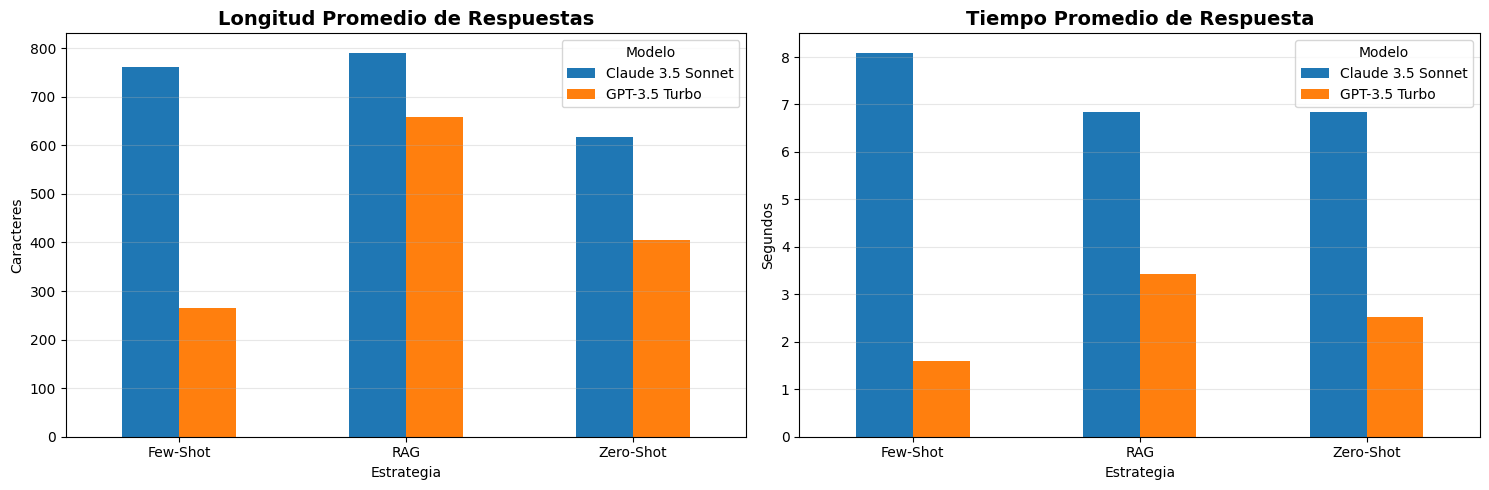


RESUMEN RÁPIDO
- GPT-3.5 Turbo: 443 caracteres promedio, 2.52s de tiempo promedio (promedio sobre todas las estrategias).
- Claude 3.5 Sonnet: 723 caracteres promedio, 7.26s de tiempo promedio (promedio sobre todas las estrategias).

Gráfico comparativo guardado en: evaluation_comparison.png

TABLA DE COMPARACIÓN ENTRE GPT-3.5 TURBO Y CLAUDE 3.5 SONNET
           Modelo Estrategia  Longitud Promedio  Tiempo Promedio
    GPT-3.5 Turbo  Zero-Shot            406.000         2.525778
    GPT-3.5 Turbo   Few-Shot            264.625         1.601397
    GPT-3.5 Turbo        RAG            659.000         3.433042
Claude 3.5 Sonnet  Zero-Shot            617.125         6.831423
Claude 3.5 Sonnet   Few-Shot            761.375         8.093941
Claude 3.5 Sonnet        RAG            791.000         6.848949


In [29]:
df_results = analyze_results(all_results)

# Mostrar tabla comparativa
print("\n" + "="*70)
print("TABLA DE COMPARACIÓN ENTRE GPT-3.5 TURBO Y CLAUDE 3.5 SONNET")
print("="*70)
print(df_results.to_string(index=False))


## 9. Exportar Modelos y Configuración

In [31]:
## 14. Preparar archivos finales para uso en Chainlit y descarga

print("Creando archivo ZIP del vector store...\n")

# Comprimir vectorstore
!zip -r -q vectorstore_guarani.zip vectorstore_guarani/

print("\n" + "="*60)
print("ARCHIVOS GENERADOS")
print("="*60)
print("1. vectorstore_guarani.zip       → Vector store FAISS listo para Chainlit")
print("2. evaluation_results.json       → Respuestas completas de ambos modelos")
print("3. evaluation_comparison.png     → Gráficos comparativos")
print("="*60)

# Descarga de archivos (solo si estamos en Colab)
try:
    from google.colab import files

    print("\nDescargando archivos...")
    files.download("vectorstore_guarani.zip")
    files.download("evaluation_results.json")
    files.download("evaluation_comparison.png")

    print("\n✓ Archivos descargados correctamente")
except ImportError:
    print("\n⚠️ No estás en Google Colab. Los archivos están en el directorio actual.")

print("\n" + "="*60)
print("PRÓXIMOS PASOS PARA CHAINLIT")
print("="*60)
print("""
1. Copia estos archivos en tu proyecto local (Chainlit):
     - vectorstore_guarani/ (descomprimir el ZIP)
     - evaluation_results.json
     - evaluation_comparison.png

2. Configura tu archivo .env:
     OPENROUTER_API_KEY=tu_api_key

3. Ejecuta la app de Chainlit:
     chainlit run app.py -w

4. Prueba el chatbot con preguntas en guaraní
5. Compara modos:
     /rag on   → RAG activado
     /rag off  → Solo modelo LLM

¡sistema RAG para guaraní está completamente listo! 🇵🇾
""")


Creando archivo ZIP del vector store...


ARCHIVOS GENERADOS
1. vectorstore_guarani.zip       → Vector store FAISS listo para Chainlit
2. evaluation_results.json       → Respuestas completas de ambos modelos
3. evaluation_comparison.png     → Gráficos comparativos

Descargando archivos...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ Archivos descargados correctamente

PRÓXIMOS PASOS PARA CHAINLIT

1. Copia estos archivos en tu proyecto local (Chainlit):
     - vectorstore_guarani/ (descomprimir el ZIP)
     - evaluation_results.json
     - evaluation_comparison.png

2. Configura tu archivo .env:
     OPENROUTER_API_KEY=tu_api_key

3. Ejecuta la app de Chainlit:
     chainlit run app.py -w

4. Prueba el chatbot con preguntas en guaraní
5. Compara modos:
     /rag on   → RAG activado
     /rag off  → Solo modelo LLM

¡sistema RAG para guaraní está completamente listo! 🇵🇾

